In [27]:
import numpy as np
import torch
from torch import nn, optim
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
from Models.selective_sequential import *
from Loss.triplet_regularized import *
from session import *
from LR_Schedule.cyclical import Cyclical
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
import util
from session import LossMeter, EvalModel
from Layers.flatten import Flatten
from torch.utils.tensorboard import SummaryWriter

In [28]:
%load_ext autoreload
%autoreload 2

torch.cuda.set_device(0); torch.backends.cudnn.benchmark=True;
torch.cuda.get_device_name(torch.cuda.current_device())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'GeForce RTX 2070 SUPER'

In [29]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

trainset = torchvision.datasets.CIFAR10(root='/media/drake/MX500/Datasets/cifar-10/train', train=True,
                                        download=True, 
                                        transform=transforms.Compose([
                                            transforms.RandomCrop(32, padding=4),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                        ]))
partial_trainset = torch.utils.data.dataset.Subset(trainset, np.arange(3200))

valset = torchvision.datasets.CIFAR10(root='/media/drake/MX500/Datasets/cifar-10/test', train=False,
                                       download=True, 
                                      transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                        ]))
partial_valset = torch.utils.data.dataset.Subset(valset, np.arange(3200))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [30]:
resnet = models.resnet18(pretrained=False)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Sequential()

select = ['act2', 'out']
model = SelectiveSequential(
    select,
    {
     'resnet': resnet,
     'fc1': nn.Linear(num_ftrs, 1024),
     'act1': nn.ReLU(True),
     'fc2': nn.Linear(1024, 512),
     'act2': nn.ReLU(True),
     'out': nn.Linear(512, 10)})

In [31]:
criterion = TripletRegularizedMultiMarginLoss(0.15, .5, select)
sess = Session(model, criterion, optim.Adam, 1e-3)

In [32]:
num_epochs = 50
validator = EmbeddingSpaceValidator(valloader, select, CustomOneHotAccuracy, 
                                    model_file="./triplet-reg.ckpt.tar")
lr_scheduler = CosAnneal(len(trainloader)*50, T_mult=2, lr_min=1e-6)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator])

In [33]:
sess.train(schedule, num_epochs)



val accuracy:  0.4684 
train loss:  0.431  train BCE :  1.7023 
valid loss:  0.4497  valid BCE :  1.6124




val accuracy:  0.5653 
train loss:  0.3464  train BCE :  1.447 
valid loss:  0.3375  valid BCE :  1.3307




val accuracy:  0.5854 
train loss:  0.2965  train BCE :  1.3208 
valid loss:  0.316  valid BCE :  1.2903




val accuracy:  0.6497 
train loss:  0.2787  train BCE :  1.2389 
valid loss:  0.2785  valid BCE :  1.1811




val accuracy:  0.6757 
train loss:  0.2651  train BCE :  1.1775 
valid loss:  0.2549  valid BCE :  1.1184




val accuracy:  0.6951 
train loss:  0.244  train BCE :  1.127 
valid loss:  0.2393  valid BCE :  1.064




val accuracy:  0.6901 
train loss:  0.225  train BCE :  1.0731 
valid loss:  0.2503  valid BCE :  1.0723




val accuracy:  0.725 
train loss:  0.2224  train BCE :  1.0522 
valid loss:  0.2207  valid BCE :  0.9947




val accuracy:  0.7357 
train loss:  0.2107  train BCE :  1.0235 
valid loss:  0.2116  valid BCE :  0.9958




val accuracy:  0.749 
train loss:  0.2084  train BCE :  0.9951 
valid loss:  0.2053  valid BCE :  0.9754




val accuracy:  0.7582 
train loss:  0.1974  train BCE :  0.9659 
valid loss:  0.1978  valid BCE :  0.928




val accuracy:  0.7492 
train loss:  0.1933  train BCE :  0.9443 
valid loss:  0.2042  valid BCE :  0.965




val accuracy:  0.7654 
train loss:  0.1846  train BCE :  0.9213 
valid loss:  0.1966  valid BCE :  0.9182




val accuracy:  0.7741 
train loss:  0.1811  train BCE :  0.9 
valid loss:  0.1902  valid BCE :  0.8925




val accuracy:  0.7867 
train loss:  0.1761  train BCE :  0.8804 
valid loss:  0.1795  valid BCE :  0.8733




val accuracy:  0.7844 
train loss:  0.1709  train BCE :  0.865 
valid loss:  0.1806  valid BCE :  0.8752




val accuracy:  0.7892 
train loss:  0.1643  train BCE :  0.8452 
valid loss:  0.1807  valid BCE :  0.846




val accuracy:  0.7884 
train loss:  0.1617  train BCE :  0.8317 
valid loss:  0.1775  valid BCE :  0.8527




val accuracy:  0.7926 
train loss:  0.1553  train BCE :  0.8212 
valid loss:  0.1786  valid BCE :  0.8336




val accuracy:  0.7983 
train loss:  0.156  train BCE :  0.8 
valid loss:  0.1754  valid BCE :  0.8409




val accuracy:  0.8057 
train loss:  0.1534  train BCE :  0.7928 
valid loss:  0.1701  valid BCE :  0.8126




val accuracy:  0.8049 
train loss:  0.1496  train BCE :  0.7747 
valid loss:  0.1673  valid BCE :  0.8079




val accuracy:  0.8137 
train loss:  0.145  train BCE :  0.761 
valid loss:  0.167  valid BCE :  0.7952




val accuracy:  0.8111 
train loss:  0.1416  train BCE :  0.7505 
valid loss:  0.1704  valid BCE :  0.7897




val accuracy:  0.8124 
train loss:  0.1354  train BCE :  0.7378 
valid loss:  0.1682  valid BCE :  0.791




val accuracy:  0.8172 
train loss:  0.138  train BCE :  0.7193 
valid loss:  0.1633  valid BCE :  0.7869




val accuracy:  0.8283 
train loss:  0.1359  train BCE :  0.7168 
valid loss:  0.1611  valid BCE :  0.7587




val accuracy:  0.8306 
train loss:  0.1298  train BCE :  0.6963 
valid loss:  0.1614  valid BCE :  0.7484




val accuracy:  0.8273 
train loss:  0.1284  train BCE :  0.6897 
valid loss:  0.1575  valid BCE :  0.7503




val accuracy:  0.833 
train loss:  0.1248  train BCE :  0.6755 
valid loss:  0.1598  valid BCE :  0.7317




val accuracy:  0.8325 
train loss:  0.1237  train BCE :  0.665 
valid loss:  0.1592  valid BCE :  0.7312




val accuracy:  0.8347 
train loss:  0.1217  train BCE :  0.6538 
valid loss:  0.1564  valid BCE :  0.7218




val accuracy:  0.8358 
train loss:  0.1192  train BCE :  0.6453 
valid loss:  0.1584  valid BCE :  0.7255




val accuracy:  0.8394 
train loss:  0.1188  train BCE :  0.6319 
valid loss:  0.1586  valid BCE :  0.7169




val accuracy:  0.8365 
train loss:  0.1152  train BCE :  0.6254 
valid loss:  0.1599  valid BCE :  0.7114




val accuracy:  0.8395 
train loss:  0.1143  train BCE :  0.615 
valid loss:  0.1559  valid BCE :  0.7124




val accuracy:  0.8409 
train loss:  0.1112  train BCE :  0.608 
valid loss:  0.1577  valid BCE :  0.703




val accuracy:  0.8439 
train loss:  0.1098  train BCE :  0.601 
valid loss:  0.1553  valid BCE :  0.6963




val accuracy:  0.8454 
train loss:  0.1074  train BCE :  0.594 
valid loss:  0.1549  valid BCE :  0.6953




val accuracy:  0.845 
train loss:  0.1096  train BCE :  0.5894 
valid loss:  0.1548  valid BCE :  0.6953




val accuracy:  0.8471 
train loss:  0.1071  train BCE :  0.5824 
valid loss:  0.1535  valid BCE :  0.6918




val accuracy:  0.8451 
train loss:  0.106  train BCE :  0.5776 
valid loss:  0.1549  valid BCE :  0.6893




val accuracy:  0.8469 
train loss:  0.1041  train BCE :  0.5735 
valid loss:  0.154  valid BCE :  0.6862




val accuracy:  0.8481 
train loss:  0.1036  train BCE :  0.5702 
valid loss:  0.1555  valid BCE :  0.6834




val accuracy:  0.849 
train loss:  0.1039  train BCE :  0.5662 
valid loss:  0.1548  valid BCE :  0.6823




val accuracy:  0.8476 
train loss:  0.1045  train BCE :  0.5651 
valid loss:  0.1544  valid BCE :  0.6848




val accuracy:  0.8468 
train loss:  0.1028  train BCE :  0.5636 
valid loss:  0.1545  valid BCE :  0.6842




val accuracy:  0.8481 
train loss:  0.0984  train BCE :  0.5618 
valid loss:  0.1549  valid BCE :  0.6813




val accuracy:  0.8472 
train loss:  0.1013  train BCE :  0.5649 
valid loss:  0.1541  valid BCE :  0.6845




val accuracy:  0.8469 
train loss:  0.1026  train BCE :  0.5614 
valid loss:  0.1544  valid BCE :  0.6825



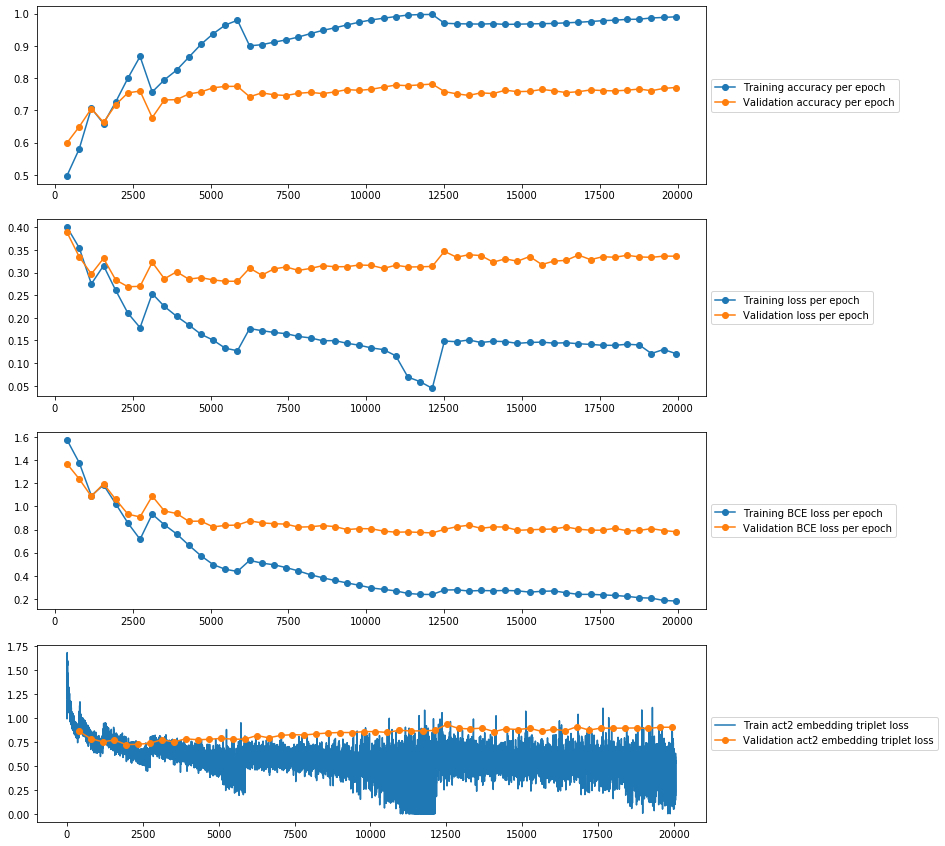

In [23]:
validator.plot()

In [ ]:
sess.load("./no-reg.ckpt.tar")

In [ ]:
total_valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
total_validator = EmbeddingSpaceValidator(total_valloader, [], CustomOneHotAccuracy)

total_validator.run(sess)

In [ ]:
np.max(total_validator.val_accuracies), "Best accuracy without reg"